In [38]:
import operator
import os
from typing import Annotated, List

from langchain_community.tools import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import Send
from langgraph.graph import MessagesState, StateGraph, START, END
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, Markdown, display


os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"


In [7]:
class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )


class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]


llm = ChatOpenAI(model="gpt-4o") 

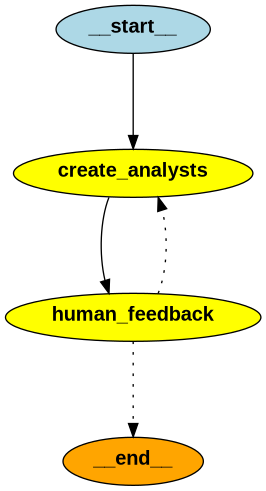

In [10]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""


def create_analysts(state: GenerateAnalystsState):
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    structured_llm = llm.with_structured_output(Perspectives)
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    pass

def should_continue(state: GenerateAnalystsState):
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    
    if human_analyst_feedback:
        return "create_analysts"

    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_png()))

In [11]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Tran
Affiliation: LangGraph Innovations
Role: Framework Research Analyst
Description: Dr. Tran focuses on the technical capabilities and innovative aspects of LangGraph, analyzing how its design and functionalities support its adoption in various scenarios.
--------------------------------------------------
Name: Mr. Andrew Sullivan
Affiliation: TechFusion Consultancy
Role: Business Applications Analyst
Description: Mr. Sullivan evaluates the practical applications of LangGraph in solving real-world business problems, emphasizing efficiency gains and adaptability in client operations.
--------------------------------------------------
Name: Ms. Priya Sharma
Affiliation: Digital Adoption Institute
Role: Industry Trends Specialist
Description: Ms. Sharma explores the broader impact of LangGraph adoption, including emerging trends in technology integration and the potential long-term benefits within the industry.
--------------------------------------------------


In [12]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [13]:
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f062004-c64e-6ef3-8002-96f68402bbcb'}}

In [14]:
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Tran
Affiliation: LangGraph Innovations
Role: Framework Research Analyst
Description: Dr. Tran focuses on the technical capabilities and innovative aspects of LangGraph, analyzing how its design and functionalities support its adoption in various scenarios.
--------------------------------------------------
Name: Mr. Andrew Sullivan
Affiliation: TechFusion Consultancy
Role: Business Applications Analyst
Description: Mr. Sullivan evaluates the practical applications of LangGraph in solving real-world business problems, emphasizing efficiency gains and adaptability in client operations.
--------------------------------------------------
Name: Ms. Priya Sharma
Affiliation: Digital Adoption Institute
Role: Industry Trends Specialist
Description: Ms. Sharma explores the broader impact of LangGraph adoption, including emerging trends in technology integration and the potential long-term benefits within the industry.
--------------------------------------------------
Name: Dr.

In [16]:
further_feedback = None
graph.update_state(thread, {"human_analyst_feedback": further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06200f-c781-6816-8004-fd948ceb19e8'}}

In [17]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [18]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
analysts

[Analyst(affiliation='Tech Dynamics Analysis Group', name='Dr. Amanda Keys', role='AI Researcher', description='Dr. Keys focuses on emergent frameworks in artificial intelligence, examining both the technical and societal impacts of adopting advanced technologies like LangGraph.'),
 Analyst(affiliation='Bright Minds Startup Incubator', name='Alex Rivera', role='Entrepreneur and Innovator', description='Alex is an entrepreneur with experience leveraging cutting-edge technologies to create startups, providing insights on business opportunities LangGraph offers.'),
 Analyst(affiliation='Systemic Synergy Consulting', name='Evelyn Bharat', role='Organizational Strategist', description="Evelyn specializes in guiding organizations through adopting new technologies and frameworks, exploring LangGraph's role in transformation strategies.")]

In [20]:
final_state.next

()

In [21]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Amanda Keys
Affiliation: Tech Dynamics Analysis Group
Role: AI Researcher
Description: Dr. Keys focuses on emergent frameworks in artificial intelligence, examining both the technical and societal impacts of adopting advanced technologies like LangGraph.
--------------------------------------------------
Name: Alex Rivera
Affiliation: Bright Minds Startup Incubator
Role: Entrepreneur and Innovator
Description: Alex is an entrepreneur with experience leveraging cutting-edge technologies to create startups, providing insights on business opportunities LangGraph offers.
--------------------------------------------------
Name: Evelyn Bharat
Affiliation: Systemic Synergy Consulting
Role: Organizational Strategist
Description: Evelyn specializes in guiding organizations through adopting new technologies and frameworks, exploring LangGraph's role in transformation strategies.
--------------------------------------------------


In [24]:
class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list


class SearchQuery(BaseModel):
    search_query: str = Field(description="Search query for retrieval.")

In [28]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""


def generate_question(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]

    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    return {"messages": [question]}

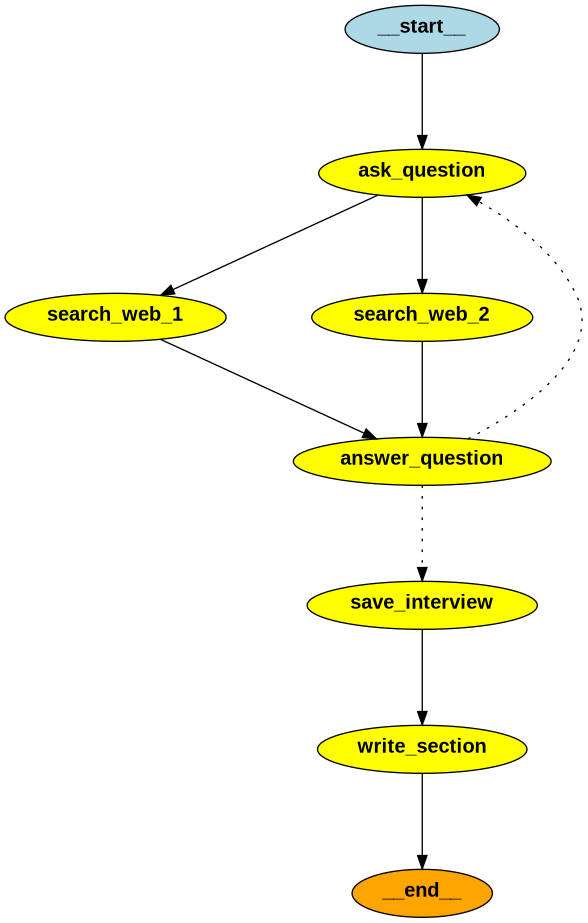

In [34]:
tavily_search = TavilySearchResults(max_results=3)

search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")


def search_web(state: InterviewState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    search_docs = tavily_search.invoke(search_query.search_query)

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""


def generate_answer(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)

    answer.name = "expert"
    return {"messages": [answer]}


def save_interview(state: InterviewState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}


def route_messages(state: InterviewState, name: str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)

    num_responses = len([m for m in messages if isinstance(m, AIMessage) and m.name == name])

    if num_responses >= max_num_turns:
        return 'save_interview'

    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"


section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""


def write_section(state: InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content=f"Use this source to write your section: {context}")]) 

    return {"sections": [section.content]}


interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web_1", search_web)
interview_builder.add_node("search_web_2", search_web)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web_1")
interview_builder.add_edge("ask_question", "search_web_2")
interview_builder.add_edge("search_web_1", "answer_question")
interview_builder.add_edge("search_web_2", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")
display(Image(interview_graph.get_graph().draw_png()))


In [35]:
analysts[0]

Analyst(affiliation='Tech Dynamics Analysis Group', name='Dr. Amanda Keys', role='AI Researcher', description='Dr. Keys focuses on emergent frameworks in artificial intelligence, examining both the technical and societal impacts of adopting advanced technologies like LangGraph.')

In [37]:
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## LangGraph: Revolutionizing Multi-Agent AI Workflows  

### Summary  
As artificial intelligence frameworks continue to evolve, LangGraph emerges as a standout solution for building stateful, multi-actor systems using Large Language Models (LLMs). Unlike traditional DAG-based frameworks, LangGraph leverages cyclical workflows that allow iterative decision-making—mirroring human-like processes. This unique feature facilitates the development of sophisticated AI applications capable of reasoning, acting dynamically, and adapting over time.  

One of LangGraph's most novel contributions to AI frameworks lies in its explicit support for cyclical graphs. These structures enable agents to loop through decision points repeatedly, refining their actions and understanding based on feedback. This contrasts with linear workflows, traditionally used in many systems, which lack the dynamic adaptability to handle complex scenarios effectively [1][2].  

What makes LangGraph particularly interesting is its flexibility. Developers can integrate multiple LLMs within workflows, each tailored to specific tasks, such as data extraction, tool invocation, or even generating email content. This node-based approach ensures specialization, adaptability in branching workflows, and scalability for real-world applications across industries [3][4].  

While LangGraph provides unparalleled flexibility and robust capabilities, it comes with complexities. The framework's low-level nature necessitates a steep learning curve, and documentation cohesion remains a challenge for developers aiming to unlock its full potential. However, early adopters, including enterprises such as Norwegian Cruise Line, have showcased its transformative impact, such as building personalized guest-facing solutions and 24/7 reliable applications [3][5].  

Key breakthroughs observed in LangGraph include:  

1. **Cyclical Workflows**: Supporting iterative loops, enabling agents to refine outputs dynamically rather than strictly adhering to linear paths [1][3].  
2. **Multi-Agent Coordination**: Parallel efforts of specialized agents, mimicking human team workflows (e.g., newsroom operations or complex support systems) [4][5].  
3. **State Management**: Robust features for tracking agent data and activity as they progress through tasks, improving transparency and debugging [3][6].  
4. **Real-World Applications**: Example use cases, such as AI travel assistants, have underscored LangGraph’s potential to combine LLMs dynamically in practical workflows [6][7].  
5. **Scalability**: Enterprise integrations highlight its ability to handle large-scale, distributed systems effectively despite some initial limitations with cloud environments like Amazon or Azure [2][5].  

LangGraph represents a significant advancement in AI frameworks, addressing limitations in earlier approaches, and offers developers the tools to build resilient, scalable, and adaptable AI systems. It paves the way for new possibilities in domains ranging from customer service to robotics and autonomous systems.  

### Sources  
[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://medium.com/@aydinKerem/which-ai-agent-framework-i-should-use-crewai-langgraph-majestic-one-and-pure-code-e16a6e4d9252  
[3] https://www.ibm.com/think/topics/langgraph  
[4] https://medium.com/@tam.tamanna18/building-production-ready-ai-agents-with-langgraph-4317a178fe9a  
[5] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[6] https://medium.com/cyberark-engineering/building-production-ready-ai-agents-with-langgraph-a-real-life-use-case-7bda34c7f4e4

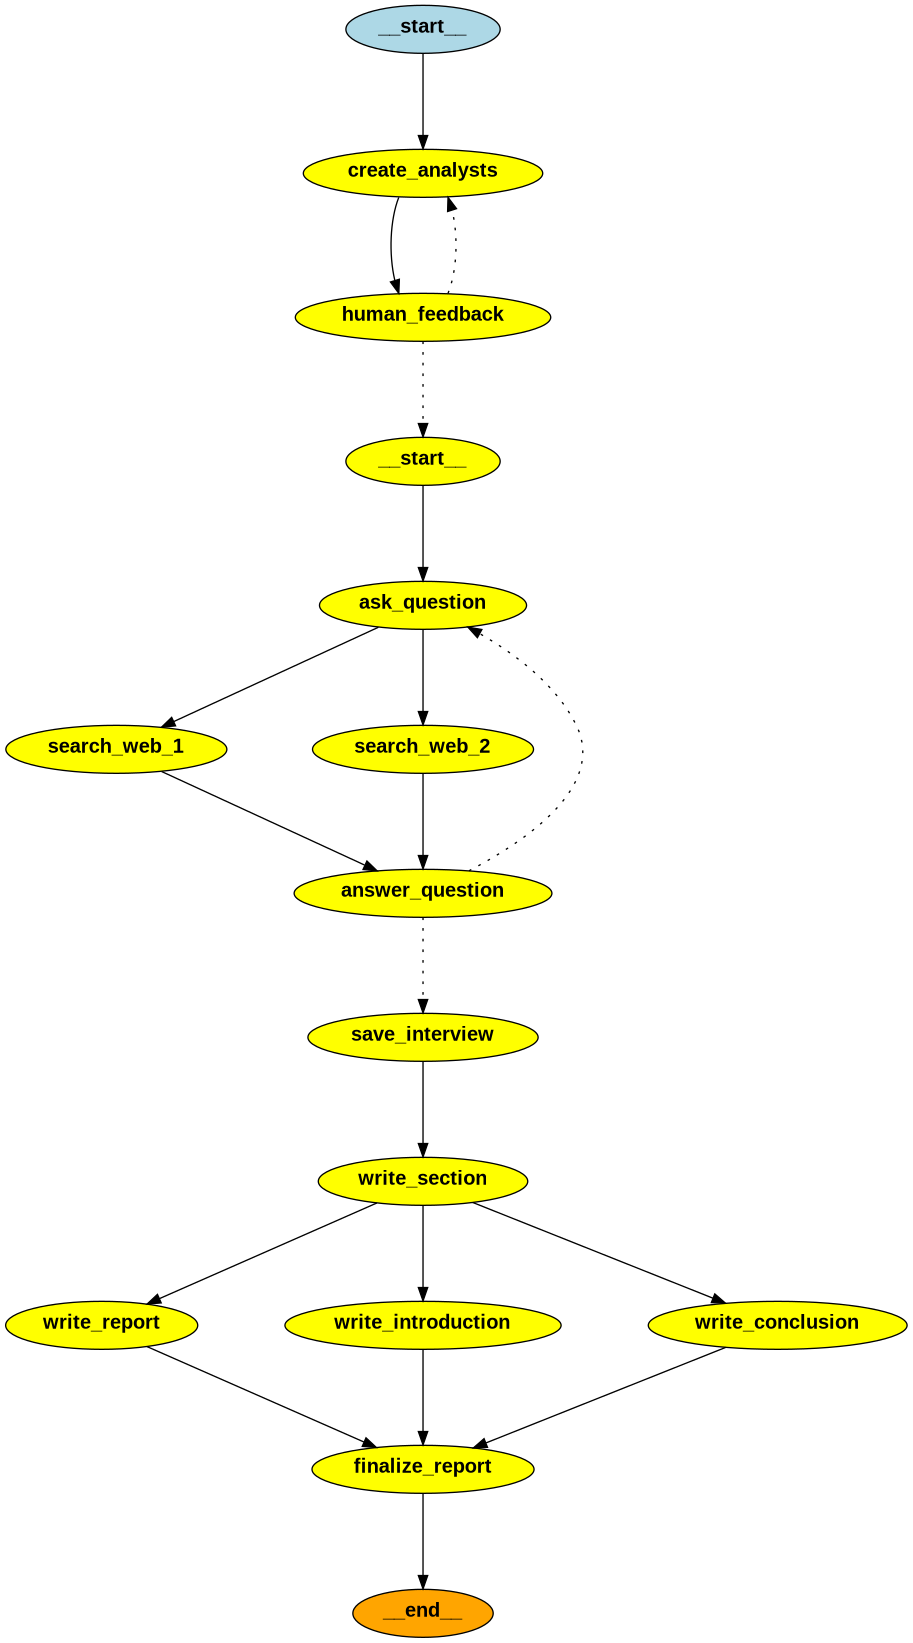

In [39]:
class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    final_report: str


def initiate_all_interviews(state: ResearchGraphState):
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"

    else:
        topic = state["topic"]
        return [
            Send("conduct_interview", {
                "analyst": analyst, 
                "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
            }) for analyst in state["analysts"]]


report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}


intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions] + [HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}


def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}


def finalize_report(state: ResearchGraphState):
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}


builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)


memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_png()))

In [40]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Olivia Mercer
Affiliation: Open Source Framework Consortium
Role: Agent Framework Specialist
Description: Dr. Mercer is an expert in agent-based frameworks and has been closely involved with LangGraph development. She examines the technical benefits and capabilities of LangGraph, considering its scalability, flexibility, and ease of adoption.
--------------------------------------------------
Name: Mr. Ethan Cross
Affiliation: Enterprise Solutions Analysis Firm
Role: Enterprise Integration Analyst
Description: Mr. Cross focuses on the integration of LangGraph in enterprise systems, evaluating its impact on business processes, ROI, and compatibility with existing infrastructure.
--------------------------------------------------
Name: Ms. Sofia Jenkins
Affiliation: Tech User Advocacy Group
Role: User Experience Advocate
Description: Ms. Jenkins represents end-users of agent frameworks, evaluating LangGraph in terms of usability, documentation quality, and the overall experienc

In [41]:
graph.update_state(thread, {"human_analyst_feedback": "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06211c-0617-67a6-8002-344bf46b8198'}}

In [42]:
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Olivia Mercer
Affiliation: Open Source Framework Consortium
Role: Agent Framework Specialist
Description: Dr. Mercer is an expert in agent-based frameworks and has been closely involved with LangGraph development. She examines the technical benefits and capabilities of LangGraph, considering its scalability, flexibility, and ease of adoption.
--------------------------------------------------
Name: Mr. Ethan Cross
Affiliation: Enterprise Solutions Analysis Firm
Role: Enterprise Integration Analyst
Description: Mr. Cross focuses on the integration of LangGraph in enterprise systems, evaluating its impact on business processes, ROI, and compatibility with existing infrastructure.
--------------------------------------------------
Name: Ms. Sofia Jenkins
Affiliation: Tech User Advocacy Group
Role: User Experience Advocate
Description: Ms. Jenkins represents end-users of agent frameworks, evaluating LangGraph in terms of usability, documentation quality, and the overall experienc

In [43]:
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06211d-7ea4-63c1-8004-e66749cc12a2'}}

In [44]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--- Node ---")
    node_name = next(iter(event.keys()))
    print(node_name)

--- Node ---
conduct_interview
--- Node ---
conduct_interview
--- Node ---
conduct_interview
--- Node ---
write_introduction
--- Node ---
write_conclusion
--- Node ---
write_report
--- Node ---
finalize_report


In [45]:
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Adopting LangGraph as an Agent Framework  

## Introduction  

LangGraph, an open-source framework built on LangChain, represents a paradigm shift in AI agent development. Unlike traditional DAG-based systems, LangGraph enables cyclical workflows essential for adaptive and stateful AI, facilitating human-like decision-making and iterative refinement. From enabling multi-agent collaboration to sustaining conversational memory, its graph-based architecture supports complex logic with unmatched flexibility. LangGraph’s versatility spans industries, powering applications like autonomous vehicles, supply chain solutions, and customer-facing AI. By combining low-code accessibility, real-time monitoring, and scalability, LangGraph emerges as an indispensable tool for CEOs and developers aiming to optimize enterprise efficiency in the era of intelligent automation.

---



LangGraph, an advanced, open-source framework developed on LangChain, introduces key innovations to the realm of AI agent development by enabling stateful, multi-agent workflows through its graph-based, cyclical architecture. Unlike traditional Directed Acyclic Graph (DAG) systems, LangGraph supports iterative loops and decision-making, making it highly adaptable for complex, adaptive workflows across multiple domains. By combining flexibility, scalability, and low-code accessibility, LangGraph has established itself as a vital tool for the next generation of AI-driven systems.  

One of LangGraph's defining features is its handling of cyclical workflows, which enable dynamic adjustments, memory retention, and contextual refinement. This capability sets it apart from other frameworks like LangChain, which is limited to linear, acyclic workflows. LangGraph's unique approach allows agents to act with iterative decision-making and continuous learning, creating highly adaptive systems that maintain conversational states, refine actions, and manage persistent memory [1][3][4]. Its utility shines in applications where interaction depth, iterative processes, or complex branching are paramount—examples include intelligent customer service, multi-turn virtual assistants, and human-in-the-loop scenarios [2][5].  

LangGraph's innovations also extend to developer control, providing tools to model workflows with precision while maintaining scalability. Its abstractions—nodes, edges, and conditional edges—simplify complex choreographies of logic, empowering developers with granular control over branching, retries, and state retention. This advanced architecture facilitates reliable agent systems that minimize potential errors while optimizing performance over time [3][5][7].  

The framework’s adaptable design is paired with robust usability features, such as a drag-and-drop, low-code interface, which lowers the barrier to entry for non-technical users while still supporting advanced customization for seasoned developers. This dual accessibility makes LangGraph ideal for both rapid prototyping and large-scale enterprise deployment. Paired with real-time debugging and workflow visualization tools, LangGraph ensures streamlined development and monitoring processes [1][4][6].  

LangGraph's industry-agnostic approach has demonstrated success across diverse domains, from customer-facing AI for companies such as Norwegian Cruise Line to adaptive systems for compliance monitoring, supply chain management, and simulation environments requiring dynamic feedback. As an extension of LangChain, it encompasses all the latter’s modular benefits while expanding the scope of workflows to include cyclical interactions, thereby addressing the needs of more advanced use cases such as multitask agents and adaptive virtual assistants [2][3][5].  

In a comparison between LangChain and LangGraph, the former remains suited for simpler projects with linear workflows, rapid prototyping, and minimal state dependencies. However, LangGraph’s ability to manage persistent states and support complex, multi-agent environments positions it as the superior choice for scalable, high-complexity endeavors. Choosing between the two frameworks depends heavily on project requirements, yet LangGraph has emerged as the innovative leader for stateful, intelligent agent systems [1][6][7].  

LangGraph’s contributions to workflow optimization, ease of deployment, and innovation in AI agent behavior enable organizations to pioneer cutting-edge AI tools and solutions while reducing development complexity. By addressing historical limitations of DAG-based systems, LangGraph positions itself as a transformative agent framework that empowers enterprises to push the boundaries of AI-driven decision-making [3][4][5].  

## Sources  

[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://www.ibm.com/think/topics/langgraph  
[3] https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6  
[4] https://arize.com/blog/langgraph/  
[5] https://www.getzep.com/ai-agents/langchain-agents-langgraph/  
[6] https://medium.com/@fabio.vargas/langgraph-studio-agentic-application-development-4c8895bb1f56  
[7] https://oxylabs.io/blog/langgraph-vs-langcha

---

## Conclusion

LangGraph represents a paradigm shift in developing scalable, intelligent AI agent systems. By enabling cyclical workflows, it overcomes the limitations of traditional DAG-based frameworks, fostering adaptive behaviors such as iterative refinement and persistent memory. With real-time debugging tools, low-code accessibility, and versatile applications across industries—from customer service to autonomous vehicles—LangGraph stands out as a compelling choice for modern enterprises. Compared to LangChain, its advanced stateful architecture and support for dynamic decision-making make it ideal for complex, multi-agent workflows. For organizations seeking innovation and operational efficiency, LangGraph offers unmatched flexibility and control, empowering next-generation AI solutions.